# Optimal power flow
**Contributed by**: Uriel Sandoval.


This notebook contains an AC-Optimal Power Flow implemented in Julia.

Following Julia packages are required to run this notebook:

* [JuMP](https://jump.dev/)  : Modeling language for mathematical optimization
* [Ipopt](https://github.com/coin-or/Ipopt): Non linear programming solver
* [PowerSystems](https://nrel-siip.github.io/PowerSystems.jl/stable/): Parse Matpower input data

Test data was obtained from [Power Grid Lib](https://github.com/power-grid-lib/pglib-opf) which is actively maintained by an [IEEE PES Task Force](https://arxiv.org/abs/1908.02788)


Many variants of the ACOPF problem formulation are relevant. However, for educational purposes and trying to be as clear as possible the following formulation is one of the most used in the AC-OPF publications and it can be found encoded in [Matpower](https://matpower.org/).


User can check the results against the ones obtained [The Power Grid Library for Benchmarking AC Optimal Power Flow Algorithms](https://arxiv.org/abs/1908.02788)


Mathematical formulation and Julia code will be mixed in the following sections to be concise in the relationship between the formulation and the programming code.



In [1]:
using JuMP, Ipopt;
using PowerSystems;

Following section reads and prepares network data.

In [2]:
# Download test case from PG-LIB repo
download("https://raw.githubusercontent.com/power-grid-lib/pglib-opf/master/pglib_opf_case14_ieee.m", "pglib_opf_case14_ieee.m")

# Read input data using PowerSystems
dat = PowerSystems.PowerModelsData("pglib_opf_case14_ieee.m").data;

# Following are aliases to PowerModelsData dictionaries
brs = dat["branch"];
buses = dat["bus"];
gens = dat["gen"];
loads = dat["load"];
shunts = dat["shunt"];

# Dimmensions of each element type
n = length(buses);
ng =  length(gens);


## Creat bus -> to element mapping
## Also index devices. The index order here defined by enumerate functions
## is mainteined in the rest of the program.

# Bus mapping: index -> id
bus_imap = Dict((i, key) for (i, key) in enumerate(keys(buses)))
for (i, key) in bus_imap
    buses[key]["_i"] = i
end


# Branch mapping: index -> id
br_imap = Dict((i, key) for (i, key) in enumerate(keys(brs)))
for (i, key) in br_imap
    branch = brs[key];
    branch["_i"] = i;
    branch["_k"] = buses[string(branch["f_bus"])]["_i"];
    branch["_m"] = buses[string(branch["t_bus"])]["_i"];
end


load_map = Dict((i, String[]) for i in keys(buses));
for (i, (key, load)) in enumerate(loads)
    load["_i"] = i;
    push!(load_map[string(load["load_bus"])], key)
end

gen_map = Dict((i, String[]) for i in keys(buses));
for (i, (key, load)) in enumerate(gens)
    load["_i"] = i;
    push!(gen_map[string(load["gen_bus"])], key)
end

shunt_map = Dict((i, String[]) for i in keys(buses));
for (i, (key, load)) in enumerate(shunts)
    load["_i"] = i;
    push!(shunt_map[string(load["shunt_bus"])], key)
end


┌ Info: removing 3 cost terms from generator 4: Float64[]
└ @ PowerSystems /Users/urielsandoval/.julia/packages/PowerSystems/hE7SB/src/parsers/pm_io/data.jl:1867
┌ Info: removing 1 cost terms from generator 1: [792.0951, 0.0]
└ @ PowerSystems /Users/urielsandoval/.julia/packages/PowerSystems/hE7SB/src/parsers/pm_io/data.jl:1867
┌ Info: removing 3 cost terms from generator 5: Float64[]
└ @ PowerSystems /Users/urielsandoval/.julia/packages/PowerSystems/hE7SB/src/parsers/pm_io/data.jl:1867
┌ Info: removing 1 cost terms from generator 2: [2326.9494, 0.0]
└ @ PowerSystems /Users/urielsandoval/.julia/packages/PowerSystems/hE7SB/src/parsers/pm_io/data.jl:1867
┌ Info: removing 3 cost terms from generator 3: Float64[]
└ @ PowerSystems /Users/urielsandoval/.julia/packages/PowerSystems/hE7SB/src/parsers/pm_io/data.jl:1867


## Network modeling

This section presents the modeling for most important devices conforming a power system

In [3]:
# Create a JuMP instance
mod = Model(Ipopt.Optimizer);

### Bus

Bus are topological elements and are the minimal network unit. Shunt devices are connected to
buses, while series devices connect two or more buses together. 

For a balanced, positive sequence equivalent network representation, each bus has several associated complex values: a voltage phasor, a current injection phasor and a complex power injection. Complex voltage magnitude can be represented in polar coordinates $\bar v = v e^{j\delta}$. Following this polar representation each bus holds two real variables: voltage magnitude $v$ and voltage angle $\delta$.

These two variables must be included for each bus $k \in \mathcal{B}$. Voltage magnitudes have
next restrictions,

$$
v_k^{\min} \leq v_k \leq v_k^{\max} \quad \forall k \in \mathcal{B}
$$,

and additionally, for the swing bus,

$$
\delta_{\text{swing}} = \delta^{\text{ref}}
$$.

In [4]:
# Add bus variables and use flat start as initial point
@variable(mod, v[1:n], start = 1.0);
@variable(mod, δ[1:n], start = 0.0);


for (i, key) in bus_imap
    bus = buses[key]
    
    # Voltage magnitude limits
    set_lower_bound(v[i], bus["vmin"]);
    set_upper_bound(v[i], bus["vmax"]);

    # Add reference angle for swing bus
    if (bus["bus_type"] == 3)
        set_lower_bound(δ[i], bus["va"]);
        set_upper_bound(δ[i], bus["va"]);
    end
end

### Branch model

The following branch model is a positive sequence model. This model has a series impedance $\bar z_{s} = r_{s} + jx_{s} = \bar y_{s}^{-1}$ and a total shunt susceptance
$b^{sh} = 2b^{sh}_k= 2b^{sh}_m$. The transformer, with a tap ratio that has a magnitude $\tau$ and a phase shift angle $\theta$, is located at the sending end of the branch, as shown in the following figure:


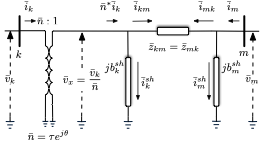



From this equivalent circuit, the complex power injected at each bus is

$$
      \begin{align}
        \bar s_k &= \bar v_k \bar i_k ^*\\
        \bar s_m &= \bar v_m \bar i_m ^*\,.
      \end{align}
$$

From Kirchhoff’s current law, the injected current $\bar i_k$ is written as

$$
      \begin{equation}
        \bar  n^* i_k = \bar i_{km} + \bar i_{k}^{sh}\,,
      \end{equation}
$$

which can be expressed in terms of nodal voltages as
$$
      \begin{align}
          \bar n ^* \bar i_k &= \bar y_{s}\left(\bar v_x - \bar v_m\right) +
                     jb_k^{sh}\bar v_x \\
                   &= \frac{\bar v_k}{\bar n} \left(\bar y_{s} + jb_k^{sh}\right) - \bar v_m \bar y_{s} \\
        \bar i_k &= \frac{\bar v_k}{\tau^2} \left(\bar y_{s} + jb_k^{sh}\right) - \frac{\bar  v_m}{\bar n^*}\bar y_{s} \,,\label{eq: ik}
      \end{align}
$$

Applying the same procedure of analysis to bus $m$ yields

$$
      \begin{align}
        \bar i_m &= \bar v_m \left(\bar y_{s} + jb_m^{sh}\right) - \frac{\bar v_k}{\bar n} \bar y_s \,. \label{eq: im}
      \end{align}
$$
By representing $\bar i_k$ and $\bar i_m$ in a matrix form the later current equations are written as

$$
      \begin{align}
        \begin{bmatrix}
        \bar i_k\\
        \bar i_m
        \end{bmatrix} &=
        \begin{bmatrix}
        \frac{1}{\tau ^2}\left(\bar y_s + jb_k^{sh}\right) &  - \frac{1}{\bar n^*}\bar y_s \\
        -\frac{1}{\bar n}\bar y_s                  & \bar y_s + jb_m^{sh}
        \end{bmatrix}
        \begin{bmatrix}
        \bar v_k \\
        \bar v_m
        \end{bmatrix}\\
        &=\begin{bmatrix}
          \bar Y_{kk}  & \bar Y_{km}\\
          \bar Y_{mk}  & \bar Y_{mm}
          \end{bmatrix}
          \begin{bmatrix}
          \bar v_k \\
          v_m
          \end{bmatrix}\,.
      \end{align}
$$

From the above representation, the net power flow injected at $k$ and $m$ is calculated as follows for the element $l$:

$$
      \begin{align}
        p_{l,k} &= v_k^2 G_{kk} + v_kv_m\left(G_{km} \cos{\delta_{km}} + B_{km} \sin{\delta_{km}}\right) \label{eq: p_k}\\
        q_{l,k} &=-v_k^2 B_{kk} + v_kv_m\left(G_{km} \sin{\delta_{km}} - B_{km} \cos{\delta_{km}}\right) \label{eq: q_k}\\
        p_{l,m} &= v_m^2 G_{mm} + v_m v_k\left(G_{mk} \cos{\delta_{mk}} + B_{mk} \sin{\delta_{mk}}\right) \label{eq: p_m}\\
        q_{l,m} &=-v_m^2 B_{mm} + v_m v_k\left(G_{mk} \sin{\delta_{mk}} - B_{mk} \cos{\delta_{mk}}\right) \label{eq: q_m}\,,
      \end{align}
$$

where
$$
      \begin{align}
        \delta_{km} &= \delta_k-\delta_m = -\delta_{mk}\\
        \bar Y_{km} &= G_{km} + jB_{km}\,. \\
      \end{align}
$$


Then, to compute the power flow in the transmission network elements it is necessary to get $\bar Y_{kk}$, $\bar Y_{km}$, $\bar Y_{mk}$, and $\bar Y_{mm}$.

Additionally the following restrictions limit the power flow in each transmission element:

$$
p_{l,k}^2 + q_{l,k}^2 \leq {s_l^{\max}}^2 \\
p_{l,m}^2 + q_{l,m}^2 \leq {s_l^{\max}}^2
$$



In [5]:
# Add branch equations. 

# Next dictionaries map bus->{Pkm, Qkm, Pmk, Qmk} 
Pinj_f_bra = Dict((i, []) for i in keys(bus_imap));
Pinj_t_bra = Dict((i, []) for i in keys(bus_imap));
Qinj_f_bra = Dict((i, []) for i in keys(bus_imap));
Qinj_t_bra = Dict((i, []) for i in keys(bus_imap));


for brn in values(brs)
    
    i = brn["_i"];
    # Get connectivity
    k = buses[string(brn["f_bus"])]["_i"];
    m = buses[string(brn["t_bus"])]["_i"];
    
    # We compute series complex impedance between buses
    Ys = 1.0 /(brn["br_r"] + im * brn["br_x"]);
    # Branch charging susceptance and conductance was already divided by two
    # in PowerSystems
    Bc = brn["b_fr"];
    Gc = brn["g_fr"];
    # Complex tap
    cTap = brn["tap"] * exp(deg2rad(brn["shift"])  * im  )
    # Admitance seing at from bus
    Ymm =  Ys + Gc + im*Bc;
    # Admitance seing at to bus
    Ykk = Ymm / brn["tap"]^2;
    # Admitance between from and to bus
    Ykm =  - Ys /conj(cTap);
    # Admitance between to and from bus
    Ymk = - Ys /cTap
    brn["Gkk"] = real(Ykk); brn["Bkk"] = imag(Ykk);
    brn["Gkm"] = real(Ykm); brn["Bkm"] = imag(Ykm);
    brn["Gmm"] = real(Ymm); brn["Bmm"] = imag(Ymm);
    brn["Gmk"] = real(Ymk); brn["Bmk"] = imag(Ymk);
        
    if (brn["br_status"] == 0)
        @info("Branch %s between buses %d and %d is inactive", key, brn["f_bus"], brn["t_bus"])
        continue
    end
    
    # Power flow between bus k and m
    Pkm = @NLexpression(mod, v[k]^2 * brn["Gkk"] +
                             v[k] * v[m] * (brn["Gkm"] *  cos(δ[k] - δ[m]) +
                                            brn["Bkm"] *  sin(δ[k] - δ[m])));
    Qkm = @NLexpression(mod, -v[k]^2 * brn["Bkk"] +
                             v[k] * v[m] * (brn["Gkm"] *  sin(δ[k] - δ[m]) -
                                            brn["Bkm"] *  cos(δ[k] - δ[m])));
    # Power flow between bus m and k
    Pmk = @NLexpression(mod, v[m]^2 * brn["Gmm"] +
                             v[m] * v[k] * (brn["Gmk"] *  cos(δ[m] - δ[k]) +
                                            brn["Bmk"] *  sin(δ[m] - δ[k])));
    Qmk = @NLexpression(mod, -v[m]^2 * brn["Bmm"] +
                             v[m] * v[k] * (brn["Gmk"] *  sin(δ[m] - δ[k]) -
                                            brn["Bmk"] *  cos(δ[m] - δ[k])));

    # Include each injection in its corresponding bus
    push!(Pinj_f_bra[k], Pkm);
    push!(Qinj_f_bra[k], Qkm);
    push!(Pinj_t_bra[m], Pmk);
    push!(Qinj_t_bra[m], Qmk);

    # In case we have a valid thermal limit we include the constraint
    if (brn["rate_a"] > 0)
        #Apparent power constrint Skm <= Smax
        @NLconstraint(mod, Pkm^2 + Qkm^2 <= brn["rate_a"]^2);
        #Apparent power constrint Smk <= Smax
        @NLconstraint(mod, Pmk^2 + Qmk^2 <= brn["rate_a"]^2);
    end
    
    
end

### Generator

Let $\mathcal{G}$ denote the set of generators. Define $p_{G_i}$ and $q_{G_i}$, respectively, as the active and reactive power outputs of the generator $i \in \mathcal{G}$. Each of these two variables is limited by upper and lower limits,


$$
p_{G_i}^{\min} \leq p_{G_i} \leq p_{G_i}^{\max} \quad \forall i \in \mathcal{G} \\
q_{G_i}^{\min} \leq q_{G_i} \leq q_{G_i}^{\max} \quad \forall i \in \mathcal{G}
$$.

In [6]:
@variable(mod, Pg[1:ng]);
@variable(mod, Qg[1:ng]);

for gen in values(gens)
    set_lower_bound(Pg[gen["_i"]], gen["pmin"] * (gen["gen_status"] == 1));
    set_upper_bound(Pg[gen["_i"]], gen["pmax"] * (gen["gen_status"] == 1));

    set_lower_bound(Qg[gen["_i"]], gen["qmin"] * (gen["gen_status"] == 1));
    set_upper_bound(Qg[gen["_i"]], gen["qmax"] * (gen["gen_status"] == 1));

end

### Active power balance constraints


Active and reactive power balance obey Kirchhoff’s current law, where the sum of currents (in this case powers) i a bus must be zero,

$$
\sum_{i \in \mathcal{G}} p_{G_i} - \sum_{i \in \mathcal{L}} p_{L_i} - 
\sum_{s \in \mathcal{S}} v_i^2 g_{s} - \sum_{(k,m) \in \mathcal{E}} p_{km}  -
\sum_{(m,k) \in \mathcal{E}} p_{mk} = 0 \quad \forall k \in \mathcal{N} \\
\sum_{i \in \mathcal{G}} q_{G_i} - \sum_{i \in \mathcal{L}} p_{L_i} + 
\sum_{s \in \mathcal{S}} v_i^2 b_{s} - \sum_{(k,m) \in \mathcal{E}} q_{km}  -
\sum_{(m,k) \in \mathcal{E}} q_{mk} = 0 \quad \forall k \in \mathcal{N}
$$

In [7]:
# Pg - Pd - Psh - Pkm == 0
@NLconstraint(mod, dP[i = 1:n], sum(Pg[gens[gen]["_i"]] for gen in gen_map[bus_imap[i]]) -
                                sum(loads[load]["pd"] for load in load_map[bus_imap[i]]) -
                                sum(shunts[shunt]["gs"] * v[i]^2 for shunt in shunt_map[bus_imap[i]]) -
                                sum(Pkm for Pkm in Pinj_f_bra[i]) -
                                sum(Pmk for Pmk in Pinj_t_bra[i]) ==0 );
# Qg - Qd + Qsh - Qkm == 0
@NLconstraint(mod, dQ[i = 1:n], sum(Qg[gens[gen]["_i"]] for gen in gen_map[bus_imap[i]]) -
                                sum(loads[load]["qd"] for load in load_map[bus_imap[i]]) +
                                sum(shunts[shunt]["bs"] * v[i]^2 for shunt in shunt_map[bus_imap[i]]) -
                                sum(Qkm for Qkm in Qinj_f_bra[i]) -
                                sum(Qmk for Qmk in Qinj_t_bra[i]) ==0 );


### Objective function

The OPF problem minimizes a specified cost function. In this formulation we minimize the production cost in the system,

$$
\min \sum_{i \in \mathcal{G}} f_{C_i}\left( P_{G_i} \right) = \sum_{i \in \mathcal{G}}\left( c_i P_{G_i}^2 + b_i P_{G_i} + c_i \right)
$$


In [8]:
@objective(mod, Min, sum(sum(gen["cost"][j] * Pg[gen["_i"]] ^(gen["ncost"] - j) for j in 1:gen["ncost"]) for gen in values(gens)));

## Solve optimization problem

In [9]:
optimize!(mod)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      217
Number of nonzeros in inequality constraint Jacobian.:      156
Number of nonzeros in Lagrangian Hessian.............:     1000

Total number of variables............................:       34
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       21
                     variables with only upper bounds:        0
Total number of equa

The above optimal objective is exactly the same as the one reported by [PoderModels](https://lanl-ansi.github.io/PowerModels.jl/stable/experiment-results/)